# Preprocessing — přehled

1. Setup — imports & environment
2. Database — načtení `historical_posts` a `historical_comments`
3. Load tickers — načtení a normalizace seznamu tickerů (NASDAQ + NYSE)
4. Data harmonization <br>
   4.1 Sjednocení schémat do `df_unified`<br>
   4.2 Placeholder-only rows analysis — analýza řádků s pouze placeholdery<br>
   4.3 Odstranění [removed]/[deleted] placeholderů<br>
   4.4 Spojení `title` + `body` pro posty do `text`<br>
5. EDA — overview, missingness, text length, temporal analysis <br>
   5.1 Data types & schema overview — kontrola datových typů<br>
   5.2 Column value distributions — unikátní hodnoty, konstantní sloupce<br>
   5.3 Overview — counts & missingness<br>
   5.4 Text characteristics — word count histograms<br>
   5.5 Temporal analysis — day/hour distribution<br>
   5.6 Engagement metrics — score & upvote ratio<br>
   5.7 Integrity and duplicates — ID uniqueness, authors<br>
6. Data Cleaning — odstranění invalidních/prázdných záznamů, deduplikace
7. Feature engineering — text_length, word_count, temporal a engagement features, weighted_score
8. Ticker detection <br>
   8.1 Detekce `mentioned_tickers`, `n_tickers`, `ticker_exchanges`<br>
   8.2 Ticker inheritance — inherit parent post tickers to comments + přepočet exchanges<br>
   8.3 Inheritance success check — analýza úspěšnosti dědění<br>
   8.4 Data Type Conversion — ensure all types persist through pipeline<br>
9. Text normalization — lowercase, odstranění URLs/interpunkce, stopword removal (tickers již v mentioned_tickers)
10. Export — konverze mentioned_tickers na CSV-friendly string, export `sentiment_ready_data.csv`
11. Process Map Visualization — Graphviz vizualizace celého pipeline

**Výstup:** `sentiment_ready_data.csv`

- **Zde dokumentace k Reddit API, kde najdete popis sloupců: https://praw.readthedocs.io/en/stable/code_overview/models/submission.html?utm_source=chatgpt.com**

- **Silně Doporučuju stahnout tady ve VScodu extension Data Wrangler od Microsoftu. Je to dobry na divani se na dataframy a jsou tam i nejaky data quality metriky a jde ten df otevrit normalne jako dalsi okno tady ve vscodu aktualizovat ho s tim jak se ten dataframe upravuje v prubehu preprocessingu. Obecne mi to prijde jako mega fajn extension.**

- **V levé liště je možná orientace v dokukmentu pomocí OUTLINE**

- **Většina použitých funkcí je definována v utils.py a importována sem.**

- Za gramatický zločiny jak v cz a en určitě nezodpovídám xd

**ENJOY THE RUN**

## 1 Setup — Imports & environment

Načteme potřebné knihovny a ověříme dostupnost spaCy/NLTK a DB driveru. To nám řekne, které nástroje můžeme použít dál pro čištění a tokenizaci textu.

In [ ]:
# 1. Setup: Imports and Configuration

import pandas as pd
import numpy as np
import logging
import os
import re
import time
from datetime import datetime
from typing import List, Set, Dict, Any
from tqdm import tqdm
from io import StringIO
import urllib.request
import urllib.parse
import matplotlib.pyplot as plt

# Environment and database imports
try:
    from dotenv import load_dotenv
    load_dotenv()
    DOTENV_AVAILABLE = True
except ImportError:
    DOTENV_AVAILABLE = False

try:
    import oracledb
    ORACLE_AVAILABLE = True
except ImportError:
    ORACLE_AVAILABLE = False
    print("Oracle DB not available. Install with: pip install oracledb")

# Checking for NLP libraries (if you lack any - install with pip install)
available_libs = []
try:
    import nltk
    NLTK_AVAILABLE = True
    available_libs.append("NLTK")

    # Check if NLTK stopwords are downloaded
    try:
        nltk.data.find('corpora/stopwords')
        print("NLTK stopwords data found")
    except LookupError:
        print("NLTK stopwords not found. Attempting to download...")
        try:
            nltk.download('stopwords', quiet=True)
            print("NLTK stopwords downloaded successfully")
        except Exception as e:
            print(f"Failed to download NLTK stopwords: {e}")
            print("   Will use fallback stopword list")
except ImportError:
    NLTK_AVAILABLE = False

try:
    import spacy
    SPACY_AVAILABLE = True
    available_libs.append("spaCy")

    # Check if spaCy model is available
    try:
        spacy.load("en_core_web_sm")
        print("spaCy 'en_core_web_sm' model found")
    except OSError:
        print("spaCy model 'en_core_web_sm' not found")
        print("   Install with: python -m spacy download en_core_web_sm")
        print("   Will fall back to NLTK if available")
except ImportError:
    SPACY_AVAILABLE = False

# Import functions from utils
from utils import (
    get_oracle_connection,
    get_all_us_tickers,
    detect_tickers_in_text,
    apply_ticker_detection,
    harmonize_schema,
    drop_invalid_texts,
    deduplicate_and_normalize_types,
    add_temporal_features,
    add_engagement_features,
    apply_text_normalization,
    remove_financial_stopwords,
    remove_stopwords_spacy
)

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# Configuration constants for minimal text lenght of texts to be considered valid and retry delay for operations
MIN_TEXT_LENGTH = 10
RETRY_DELAY = 10

print(f"Step 1: imports loaded — available: {', '.join(available_libs) if available_libs else 'none'}")

Step 1: imports loaded — available: none


## 2 Database — Extract posts & comments

Připojíme se k databázi (nebo načteme z cache) a stáhneme posty a komentáře. 

In [ ]:
# 2. Database Connection: Loading Reddit Data from Oracle

print("Step 2: importing Reddit data from Oracle database")

# Check if Oracle DB is available and credentials are set in environment variables
oracle_credentials_available = (
    ORACLE_AVAILABLE and
    os.getenv('db-username') and
    os.getenv('db-password') and
    os.getenv('db-dsn')
)

if oracle_credentials_available:
    print("Oracle credentials found, so far so good...")

    conn = get_oracle_connection()

    if conn:
        print("Database connection successful")

        # Importing data from database
        try:
            # Query to import posts (number of them is set to 1000 for testing, but can be set in the variable)
            query_posts = """
                SELECT
                    author, title, created_utc, id, is_original_content,
                    score, DBMS_LOB.SUBSTR(body, 4000, 1) as body,
                    subreddit, upvote_ratio, url
                FROM historical_posts
                WHERE ROWNUM <= 1000
            """
            df_posts = pd.read_sql_query(query_posts, conn)

            # Query to import comments (number of them is set to 1000 for testing, but can be set in the variable)
            query_comments = """
                SELECT
                    author, created_utc, id, parent_post_id, score,
                    DBMS_LOB.SUBSTR(body, 4000, 1) as body,
                    subreddit
                FROM historical_comments
                WHERE ROWNUM <= 1000
            """
            df_comments = pd.read_sql_query(query_comments, conn)

            # Closing connection immediately after data import so that it does not stay open longer than needed
            conn.close()

            print(f"\nPosts imported: {df_posts.shape}")
            print(f"Comments imported: {df_comments.shape}")

            if len(df_posts) > 0:
                print(f"Posts columns: {list(df_posts.columns)}")

            if len(df_comments) > 0:
                print(f"Comments columns: {list(df_comments.columns)}")

        except Exception as e:
            print(f"Error importing data from database: {e}")
            if conn:
                try:
                    conn.close()
                except:
                    pass
            df_posts = pd.DataFrame()
            df_comments = pd.DataFrame()

    else:
        print("Failed to connect to database - check logs, kinda cooked you are")
        df_posts = pd.DataFrame()
        df_comments = pd.DataFrame()

else:
    print("Oracle database credentials not configured — set them in .env file or environment variables")
    df_posts = pd.DataFrame()
    df_comments = pd.DataFrame()

print(f"\nStep 2 complete: Loaded {len(df_posts)} posts and {len(df_comments)} comments. Letzgoo")

Step 2: importing Reddit data from Oracle database
Oracle credentials found, so far so good...
Oracle connection successful!
Database connection successful


/var/folders/5k/xsh6xzj10l121lg2lr_6rpkm0000gn/T/ipykernel_16771/150199243.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_posts = pd.read_sql_query(query_posts, conn)


KeyboardInterrupt: 

In [3]:
print(df_posts.head())


                 AUTHOR                                              TITLE  \
0           BrockForsey  40K in traditional IRA. Should I transfer to m...   
1  Legitimate_Author_20  could you a suggestion for splitting my 50,000...   
2             fxroy5673  ✅ I Offer clear, concise signals backed by tho...   
3  Few-Professional-859                Good time for semiconductor stocks?   
4         CyrilPCallist             Begineer looking for investing advice    

   CREATED_UTC       ID  IS_ORIGINAL_CONTENT  SCORE  \
0   1721474597  1e7tfbb                    0      3   
1   1721475391  1e7tmnc                    0      1   
2   1721475575  1e7tobx                    0      1   
3   1721477170  1e7u4jj                    0      1   
4   1721480593  1e7v5s3                    0      1   

                                                BODY  SUBREDDIT  UPVOTE_RATIO  \
0  Potentially relevant details: 36 yo, married, ...  investing          0.57   
1                                     

In [4]:
print(df_posts)

                   AUTHOR                                              TITLE  \
0             BrockForsey  40K in traditional IRA. Should I transfer to m...   
1    Legitimate_Author_20  could you a suggestion for splitting my 50,000...   
2               fxroy5673  ✅ I Offer clear, concise signals backed by tho...   
3    Few-Professional-859                Good time for semiconductor stocks?   
4           CyrilPCallist             Begineer looking for investing advice    
..                    ...                                                ...   
995            Astrid-427        What's the most underrated stock right now?   
996           chinoaleman  Why is $KSS so low despite a good P/E ratio? W...   
997            Astrid-427                Do you consider $RICK a good stock?   
998           nachihapter  Response to Thread - 'Should we buy Reddit (RD...   
999      Efficient-Ad3985         Seeking Help with Stock Pitch Presentation   

     CREATED_UTC       ID  IS_ORIGINAL_

## 3 Load tickers — Ticker list & exchanges

Načteme a normalizujeme seznam tickerů (lokálně nebo ze zdroje) - podívej se na strukturu toho csvcka. Podíváme se na rozložení tickerů dle burzy (vychází pořád z toho csvcka).

In [5]:
# 3. Ticker Data Loading: Fetch NASDAQ/NYSE Symbols
us_tickers_path = "us_tickers.csv"

if os.path.exists(us_tickers_path):
    try:
        tickers_df = pd.read_csv(us_tickers_path, dtype=str)
        tickers_df.columns = [c.strip().lower().replace(" ", "_") for c in tickers_df.columns]
        if 'ticker' in tickers_df.columns:
            tickers_df['ticker'] = tickers_df['ticker'].astype(str).str.upper().str.strip()
        print(f"Loaded {len(tickers_df)} cached tickers")
    except Exception as e:
        print(f"Error loading cached data: {e}")
        tickers_df = None
else:
    tickers_df = None

# If no cached data or fresh data
if tickers_df is None or len(tickers_df) == 0:
    try:
        tickers_df = get_all_us_tickers()
        if len(tickers_df) > 0:
            tickers_df.to_csv(us_tickers_path, index=False)
            print(f"Fetched and cached {len(tickers_df)} US tickers")
        else:
            print("No ticker data retrieved - this should not happen xd")
    except Exception as e:
        print(f"Error fetching ticker data: {e}")
        tickers_df = pd.DataFrame()

if len(tickers_df) > 0:
    print(f"  Exchanges: {tickers_df['exchange'].value_counts().to_dict()}")

else:
    print("No ticker data available - ur cooked bro")

print(f"\nStep 3 complete: Loaded {len(tickers_df)} ticker symbols. Letzgoo")

Loaded 8003 cached tickers
  Exchanges: {'NASDAQ': 5118, 'NYSE': 2885}

Step 3 complete: Loaded 8003 ticker symbols. Letzgoo


## 4 Data harmonization — unify posts & comments

Sjednotíme posts a comments do jednoho `df_unified` s konzistentními sloupci (id, text, type, title, parent_post_id...). Myslel jsem, že tohle bude dočasný řešení (takový temporary zjednoduseni) a divani se na posty a komenty uplne stejne, ale nakonec jde skrze parent_post_id hezky mapovat napříč daty takže bych to dělal takhle (bude dávat větší smysl to co píšu v dalších krocích i guess).

### 4.1 Unifying posts & comments

Sloučíme **df_posts** a **df_comments**, přemapujeme názvy a vytvoříme jednotný sloupec `text`, ktery bude ten nejdulezitejsi sloupec na pozdejsi analyzu basically. Tady je ořekávané to, že u sloupců, které posty mají jen posty, vzniknou v tom samém sloupci pro komentáře NAs. A naopak. To je v pořádku a řešíme to dále.

In [6]:
# 4. Data Harmonization: Merge Posts and Comments

if len(df_posts) > 0 or len(df_comments) > 0:
    # combining data
    df_unified = harmonize_schema(df_posts, df_comments)
    print(f"Unified dataframe shape: {df_unified.shape}")
    print(f"Unified columns: {list(df_unified.columns)}")

    # data type distribution
    type_counts = df_unified['type'].value_counts()
    print(f"\nData distribution:")
    for dtype, count in type_counts.items():
        print(f"  {dtype}: {count} rows")

else:
    print("No data to harmonize")
    df_unified = pd.DataFrame()

print(f"\nStep 4.1 complete: Unified {len(df_unified)} rows. Letzgoo")

/Users/ozetek/Documents/Škola/5. semestr/TA2/stock-sentiment-analysis/utils.py:298: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unified = pd.concat([posts, comments], ignore_index=True, sort=False)
INFO:utils:Harmonized schema. Unified dataframe shape: (2000, 12)


Unified dataframe shape: (2000, 12)
Unified columns: ['author', 'title', 'created_utc', 'id', 'is_original_content', 'score', 'text', 'subreddit', 'upvote_ratio', 'url', 'parent_post_id', 'type']

Data distribution:
  post: 1000 rows
  comment: 1000 rows

Step 4.1 complete: Unified 2000 rows. Letzgoo


In [7]:
print(df_unified.head())

                 author                                              title  \
0           BrockForsey  40K in traditional IRA. Should I transfer to m...   
1  Legitimate_Author_20  could you a suggestion for splitting my 50,000...   
2             fxroy5673  ✅ I Offer clear, concise signals backed by tho...   
3  Few-Professional-859                Good time for semiconductor stocks?   
4         CyrilPCallist             Begineer looking for investing advice    

   created_utc       id is_original_content  score  \
0   1721474597  1e7tfbb                   0      3   
1   1721475391  1e7tmnc                   0      1   
2   1721475575  1e7tobx                   0      1   
3   1721477170  1e7u4jj                   0      1   
4   1721480593  1e7v5s3                   0      1   

                                                text  subreddit  upvote_ratio  \
0  Potentially relevant details: 36 yo, married, ...  investing          0.57   
1                                          [

### 4.2 Placeholder-only rows analysis

Některé řádky mají **pouze** placeholdery ([removed]/[deleted]) - tohle bylo zjisteno na zaklade inspekce dataframu, ale stejně by to bylo zjištěno později. Tyhle sloupce nemají žádný skutečný obsah → budou smazány v dalším kroku. Tady se podíváme kolik takových řádků máme, a jak jsou rozloženy podle typu (posty vs komenty).

In [8]:
if len(df_unified) == 0:
    print("No data")
else:
    def is_placeholder(s):
        if pd.isna(s):
            return True
        s = str(s).strip().lower()
        return s == '' or s in {'[deleted]', '[removed]', 'nan'}

    text_placeholder = df_unified['text'].apply(is_placeholder)
    title_placeholder = df_unified.get('title', pd.Series(False, index=df_unified.index)).apply(is_placeholder)

    to_drop_mask = (
        ((df_unified['type'] == 'post') & title_placeholder & text_placeholder) |
        ((df_unified['type'] == 'comment') & text_placeholder)
    )

    if to_drop_mask.any():
        print("\nPlaceholder-Only Rows by Type:")

        for t, grp in df_unified[to_drop_mask].groupby('type'):
            print(f"  {t.upper()}: {len(grp):,} rows will be deleted")

            if t == 'post':
                for col in ['title', 'text']:
                    removed = (grp[col].str.strip().str.lower() == '[removed]').sum()
                    deleted = (grp[col].str.strip().str.lower() == '[deleted]').sum()
                    print(f"    {col}: [removed]={removed:,}, [deleted]={deleted:,}")
            else:
                txt = grp['text'].astype(str).str.strip().str.lower()
                removed = (txt == '[removed]').sum()
                deleted = (txt == '[deleted]').sum()
                empty = (txt == '').sum()
                print(f"    text: [removed]={removed:,}, [deleted]={deleted:,}, empty/NA={empty:,}")
    else:
        print("No placeholder-only rows found.")


Placeholder-Only Rows by Type:
  COMMENT: 34 rows will be deleted
    text: [removed]=33, [deleted]=1, empty/NA=0


**Oukej, vypadá to, že vždy jsou plný placeholderů jen komenty (většinou [removed])** S lehkým srdcem toto 1% dat mažem v příštím kroku xd

### 4.3 deleting [removed]/[deleted] placeholders (**NOT REMOVING MISSING VALUES - THESE ARE HANDLED LATER**)

Místo samotných NAs, je v nadpisech Tohle je udelany, abychom pri pozdejsim feature engineeringu nedostali neco jako: "Emotional investing research. [removed]"

In [9]:
# turning placeholders into empty string
if 'title' in df_unified.columns:
    df_unified['title'] = df_unified['title'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())
if 'text' in df_unified.columns:
    df_unified['text'] = df_unified['text'].apply(lambda x: '' if is_placeholder(x) else str(x).strip())

# Droping posts where both title and text are empty after cleaning
before = len(df_unified)
mask_empty_post = (df_unified['type'] == 'post') & (df_unified.get('title', '').astype(str).str.strip() == '') & (df_unified.get('text', '').astype(str).str.strip() == '')
mask_empty_comment = (df_unified['type'] == 'comment') & (df_unified.get('text', '').astype(str).str.strip() == '')

# For comments we will drop those with empty body. For posts we will drop only if both title+text empty
to_drop = mask_empty_post | mask_empty_comment
df_unified = df_unified[~to_drop].reset_index(drop=True)
after = len(df_unified)
print(f"We removed {before - after} placeholder-only rows (kept posts with title if present).")

We removed 34 placeholder-only rows (kept posts with title if present).


### 4.4 Merging title + body for posts into **text** column

U postů spojíme `title` s tělem, protože titul často obsahuje klíčovou informaci nebo ticker. Title a to tělo spolu přímo souvisí a je to vlastně jedna entita (tedy post). Reálně není důvod proč to neudělat a navíc můžeme poté smazat sloupec title, který byl stejně z půlky NAs (komentare nemaji title), což prakticky nevadilo ale vis co o sloupec min lol. Zvýší to později šanci, že detekce tickerů a sentimentu zachytí o čem post reálně je.

In [10]:
# 4.4 Enhanced Text: Merge Title + Body for Posts

if len(df_unified) > 0:

    # For posts: concatenate title + body
    # For comments: keep body only (no title)
    def create_enhanced_text(row):
        if row['type'] == 'post':
            title = str(row.get('title', '')).strip()
            body = str(row.get('text', '')).strip()
            # Combine title and body with separator
            if title and title != 'nan' and body and body != 'nan':
                return f"{title}. {body}"
            elif title and title != 'nan':
                return title
            elif body and body != 'nan':
                return body
            else:
                return ''
        else:
            # Comments: use text only
            return str(row.get('text', '')).strip()

    df_unified['enhanced_text'] = df_unified.apply(create_enhanced_text, axis=1)

    # Replace 'text' column with enhanced version
    df_unified['text'] = df_unified['enhanced_text']
    df_unified.drop(columns=['enhanced_text'], inplace=True)

    # We can safely rop title column since it's now merged into text (and later ticker detection is done on the "text" column)
    if 'title' in df_unified.columns:
        df_unified.drop(columns=['title'], inplace=True)
        print("Dropped 'title' column (merged into 'text')")

    print(f"Done")

else:
    print("No data to enhance")

Dropped 'title' column (merged into 'text')
Done


## 5 Exploratory Data Analysis (EDA)

Projdeme kvalitu dat a základní statistiky, abychom věděli jak data dál (pokud je to potřeba) upravit.

### 5.1 Data types chekc/conversion & schema overview

Zkontrolujeme datové typy všech sloupců a případně je upravíme. To nám pomůže identifikovat potenciální problémy v datech a zajistit správné zpracování v dalších krocích.

In [11]:
# 5.1 Data types check

if len(df_unified) > 0:
    print(f"Dataset shape: {df_unified.shape}")

    for col in df_unified.columns:
        dtype = df_unified[col].dtype
        print(f"  {col:20} : {str(dtype):15}")

else:
    print("No data available")

Dataset shape: (1966, 11)
  author               : object         
  created_utc          : int64          
  id                   : object         
  is_original_content  : object         
  score                : int64          
  text                 : object         
  subreddit            : object         
  upvote_ratio         : float64        
  url                  : object         
  parent_post_id       : object         
  type                 : object         


**Everything seems fine. Data type conversion is now performed after Step 8.2 (ticker inheritance) to ensure types persist through the entire pipeline.**

### 5.2 Column value distributions

Prozkoumáme rozložení hodnot ve sloupcích - počty unikátních hodnot, konstantní sloupce a základní distribuce kategorických proměnných.

In [12]:
# 5.2 Column Value Distributions

if len(df_unified) > 0:
    print("\nUnique Value Counts:")

    for col in df_unified.columns:
        n_unique = df_unified[col].nunique()
        n_total = len(df_unified)
        pct_unique = (n_unique / n_total) * 100

        print(f"  {col:20} : {n_unique:,} unique values ({pct_unique:.1f}% of total)")

    print(f"\nStep 5.2 completed")

else:
    print("No data available")


Unique Value Counts:
  author               : 1,546 unique values (78.6% of total)
  created_utc          : 1,956 unique values (99.5% of total)
  id                   : 1,966 unique values (100.0% of total)
  is_original_content  : 1 unique values (0.1% of total)
  score                : 100 unique values (5.1% of total)
  text                 : 1,915 unique values (97.4% of total)
  subreddit            : 3 unique values (0.2% of total)
  upvote_ratio         : 85 unique values (4.3% of total)
  url                  : 990 unique values (50.4% of total)
  parent_post_id       : 216 unique values (11.0% of total)
  type                 : 2 unique values (0.1% of total)

Step 5.2 completed


**[is_original_content] má jen hodnotu 0, takže ho později dropnem. Nic jinýho podlě mě neznačí nějaký problémy kvůli kterým by stálo za to tohle nějak dále analyzovat či data upravovat.**

### 5.3 Overview — counts & missingness 

Spočítáme počty, podíly chybějících hodnot a zjistíme, kolik záznamů je smazaných nebo prázdných (NAs).

In [13]:
# 5.3 Data Quality & Completeness
if len(df_unified) > 0:

    print("\nNAs by Column:")
    for col in df_unified.columns:
        missing_count = df_unified[col].isna().sum()
        if missing_count > 0:
            missing_pct = (missing_count / len(df_unified)) * 100
            print(f"  {col}: {missing_count:,} ({missing_pct:.1f}%)")

else:
    print("No data available for quality analysis.")


NAs by Column:
  is_original_content: 966 (49.1%)
  upvote_ratio: 966 (49.1%)
  url: 974 (49.5%)
  parent_post_id: 1,000 (50.9%)


Všechno je v pořádku — chybějící hodnoty v  [is_original_content], [upvote_ratio], [url], [parent_post_id] jsou strukturální (posty vs. komentáře mají původně různé sloupce). V data cleaning dropneme is_original_content, url. **Naopak [parent_post_id] určitě nedropujeme.** <br>

Very short texts (≤5 chars): 104 — ty budou odstraněny v kroku 6 (drop_invalid_texts). <br>

### 5.4 Text characteristics

Podíváme se na délky textů, počty slov a percentily, abychom kdyžtak vyfiltrovali moc krátký/dlouhý (druhá možnost spíše ne, není proč). 

In [14]:
# 5.4 Text Characteristics

if len(df_unified) > 0 and 'text' in df_unified.columns:

    # Calculating text statistics
    valid_texts = df_unified[df_unified['text'].notna() & (df_unified['text'] != '')]

    if len(valid_texts) > 0:
        text_lengths = valid_texts['text'].astype(str).str.len()

        word_counts = valid_texts['text'].astype(str).str.split().str.len()

        print(f"\nWord Count Statistics (Overall):")
        print(f"  Mean: {word_counts.mean():.1f} words")
        print(f"  Median: {word_counts.median():.1f} words")
        print(f"  Min: {word_counts.min()} words")
        print(f"  Max: {word_counts.max()} words")

        try:
            import matplotlib.pyplot as plt
            if 'type' in valid_texts.columns:
                posts = valid_texts[valid_texts['type'] == 'post']
                comments = valid_texts[valid_texts['type'] == 'comment']

                if len(posts) > 0 and len(comments) > 0:
                    post_word_counts = posts['text'].astype(str).str.split().str.len()
                    comment_word_counts = comments['text'].astype(str).str.split().str.len()

                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

                    # Posts
                    ax1.hist(post_word_counts, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
                    ax1.axvline(post_word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {post_word_counts.mean():.1f}')
                    ax1.axvline(post_word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {post_word_counts.median():.1f}')
                    ax1.set_xlabel('Number of Words')
                    ax1.set_ylabel('Frequency')
                    ax1.set_title(f'Posts - Word Count Distribution (n={len(posts):,})')
                    ax1.legend()
                    ax1.grid(axis='y', alpha=0.3)

                    # Comments
                    ax2.hist(comment_word_counts, bins=50, edgecolor='black', alpha=0.7, color='coral')
                    ax2.axvline(comment_word_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {comment_word_counts.mean():.1f}')
                    ax2.axvline(comment_word_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {comment_word_counts.median():.1f}')
                    ax2.set_xlabel('Number of Words')
                    ax2.set_ylabel('Frequency')
                    ax2.set_title(f'Comments - Word Count Distribution (n={len(comments):,})')
                    ax2.legend()
                    ax2.grid(axis='y', alpha=0.3)

                    plt.tight_layout()
                    plt.show()
                else:
                    print("  Not enough data for separate histograms")

        except ImportError:
            print("matplotlib not available - install with: pip install matplotlib")

        # Short texts identification
        very_short = (text_lengths <= MIN_TEXT_LENGTH).sum()
        print(f"\nQuality Issues:")
        print(f"  Texts ≤{MIN_TEXT_LENGTH} chars: {very_short:,} ({very_short/len(valid_texts)*100:.1f}%)")

else:
    print("No text data")


Word Count Statistics (Overall):
  Mean: 55.9 words
  Median: 21.0 words
  Min: 1 words
  Max: 739 words
matplotlib not available - install with: pip install matplotlib

Quality Issues:
  Texts ≤10 chars: 43 (2.2%)


**Reálně tu není moc řešit. Tak asi nějak co bychom očekávali. Ten rozdíl není nijak margantní, ale i kdyby byl tak pro účely našeho tasku něco jako outlier v počtu slov neexistuje xd.**

### 5.5 Temporal analysis

Zkontrolujeme časové rozložení příspěvků (denní/hodinové špičky a rozsah dat). To zajímá jen mě osobně, nejspíš to nebude důležitý, but u never know.

In [15]:
# 5.5 Temporal Analysis

if len(df_unified) > 0 and 'created_utc' in df_unified.columns:

    # Converting to datetime
    valid_dates = df_unified[df_unified['created_utc'].notna()].copy()

    if len(valid_dates) > 0:
        valid_dates['datetime'] = pd.to_datetime(valid_dates['created_utc'], unit='s')

        # Date range
        print(f"\nDate Range:")
        print(f"  Earliest: {valid_dates['datetime'].min()}")
        print(f"  Latest: {valid_dates['datetime'].max()}")
        print(f"  Span: {(valid_dates['datetime'].max() - valid_dates['datetime'].min()).days} days")

        valid_dates['date'] = valid_dates['datetime'].dt.date
        valid_dates['hour'] = valid_dates['datetime'].dt.hour
        valid_dates['day_of_week'] = valid_dates['datetime'].dt.day_name()
        valid_dates['month'] = valid_dates['datetime'].dt.month

        # Posts per day
        daily_counts = valid_dates.groupby('date').size()
        print(f"  Mean posts per day: {daily_counts.mean():.1f}")

        # temporal patterns
        print(f"\nTemporal Distribution Charts:")
        try:
            import matplotlib.pyplot as plt

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

            day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
            day_counts = valid_dates['day_of_week'].value_counts()
            day_counts_ordered = [int(day_counts.get(d, 0)) for d in day_order]
            ax1.bar(range(7), day_counts_ordered, color='steelblue', alpha=0.7, edgecolor='black')
            ax1.set_xlabel('Day of Week')
            ax1.set_ylabel('Number of Posts')
            ax1.set_title('Activity by Day of Week')
            ax1.set_xticks(range(7))
            ax1.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
            ax1.grid(axis='y', alpha=0.3)

            hour_counts = valid_dates['hour'].value_counts()
            hours = list(range(24))
            counts = [hour_counts.get(h, 0) for h in hours]
            ax2.bar(hours, counts, color='coral', alpha=0.7, edgecolor='black')
            ax2.set_xlabel('Hour of Day')
            ax2.set_ylabel('Number of Posts')
            ax2.set_title('Hourly Activity Distribution')
            ax2.set_xticks(range(0, 24, 2))
            ax2.grid(axis='y', alpha=0.3)

            plt.tight_layout()
            plt.show()

        except ImportError:
            print("  matplotlib not available - install with: pip install matplotlib")

    print()
else:
    print("Warning: No temporal data available for analysis")


Date Range:
  Earliest: 2024-02-03 13:20:21
  Latest: 2024-11-13 23:17:45
  Span: 284 days
  Mean posts per day: 42.7

Temporal Distribution Charts:
  matplotlib not available - install with: pip install matplotlib



**Oukej, peak je úterý/středa a většinou odpolední/večerní hodiny.**

### 5.6 Upvote ratio analysis

Analyzujeme upvote_ratio - poměr kladných hodnocení (upvotes / (upvotes + downvotes)). Tato metrika je dostupná pouze pro posty.

  Mean: 0.825
  Median: 1.000
  Min: 0.080
  Max: 1.000

Upvote Ratio Histogram:


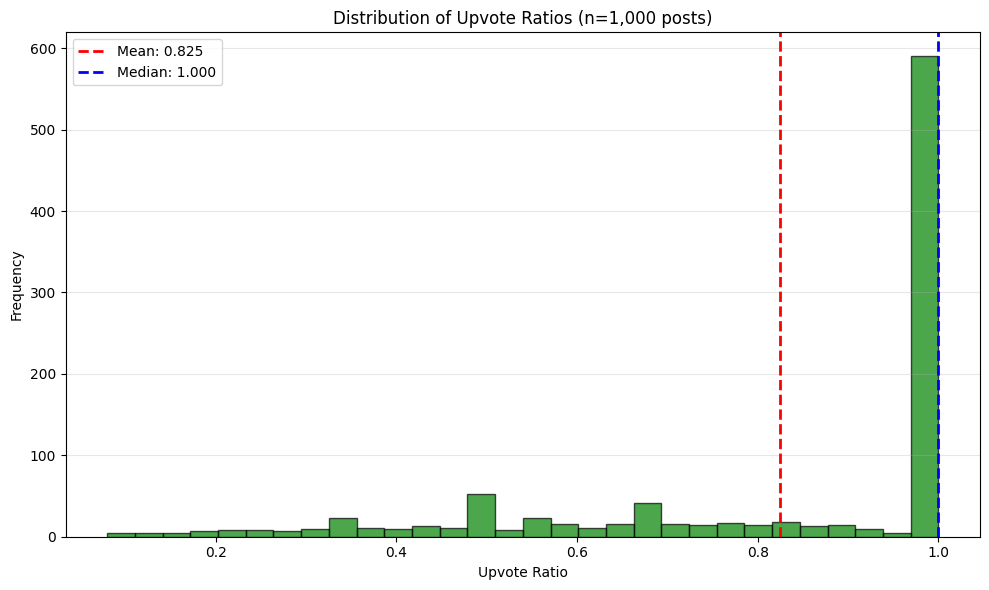

In [ ]:
# 5.6 Upvote Ratio Analysis

if len(df_unified) > 0:
    if 'upvote_ratio' in df_unified.columns:
        posts = df_unified[df_unified['type'] == 'post']

        if len(posts) > 0 and 'upvote_ratio' in posts.columns:
            upvote_ratios = posts['upvote_ratio'].dropna()

            if len(upvote_ratios) > 0:
                print(f"  Mean: {upvote_ratios.mean():.3f}")
                print(f"  Median: {upvote_ratios.median():.3f}")
                print(f"  Min: {upvote_ratios.min():.3f}")
                print(f"  Max: {upvote_ratios.max():.3f}")


            print(f"\nUpvote Ratio Histogram:")

            fig, ax = plt.subplots(1, 1, figsize=(10, 6))

            # Histogram
            ax.hist(upvote_ratios, bins=30, edgecolor='black', alpha=0.7, color='green')
            ax.axvline(upvote_ratios.mean(), color='red', linestyle='--', linewidth=2,
                        label=f'Mean: {upvote_ratios.mean():.3f}')
            ax.axvline(upvote_ratios.median(), color='blue', linestyle='--', linewidth=2,
                        label=f'Median: {upvote_ratios.median():.3f}')
            ax.set_xlabel('Upvote Ratio')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Distribution of Upvote Ratios (n={len(upvote_ratios):,} posts)')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)

            plt.tight_layout()
            plt.show()

else:
    print("Warning: No data available for upvote ratio analysis")

Ratio se pohybuje od 0 do 1, většinou velmi pozitivní ratio. 

### 5.7 Integrity and duplicates

Najdeme duplicitní ID a další integrity problémy (chybějící ID, extrémně krátké texty, dále taky podmínka a check na NAs).

In [18]:
# 5.7 Data Integrity & Duplicates

if len(df_unified) > 0:

    # Duplicate IDs
    if 'id' in df_unified.columns:
        total_ids = len(df_unified)
        unique_ids = df_unified['id'].nunique()
        duplicate_ids = total_ids - unique_ids

        print(f"  Total rows: {total_ids:,}")
        print(f"  Unique IDs: {unique_ids:,}")
        print(f"  Duplicate IDs: {duplicate_ids:,} ({duplicate_ids/total_ids*100:.2f}%)")

        if duplicate_ids > 0:
            dup_counts = df_unified['id'].value_counts()
            most_duplicated = dup_counts[dup_counts > 1].head(5)
            print(f"\n  Most duplicated IDs:")
            for id_val, count in most_duplicated.items():
                print(f"    {id_val}: appears {count} times")

    # potential issues
    print(f"\nPotential Data Issues:")
    issues_found = 0

    critical_fields = ['id', 'text', 'created_utc']
    for field in critical_fields:
        if field in df_unified.columns:
            na_count = df_unified[field].isna().sum()
            if na_count > 0:
                print(f"  Warning {field}: {na_count:,} missing values")
                issues_found += 1

    if 'text' in df_unified.columns:
        deleted = df_unified['text'].isin(['[deleted]', '[removed]']).sum()
        if deleted > 0:
            print(f"  Warning: Deleted/removed content: {deleted:,} rows")
            issues_found += 1

    if 'text' in df_unified.columns:
        very_short = (df_unified['text'].astype(str).str.len() <= 5).sum()
        if very_short > 0:
            print(f"  Warning: Extremely short texts (≤5 chars): {very_short:,} rows")
            issues_found += 1

    if issues_found == 0:
        print("No major data quality issues detected")

else:
    print("No data available for integrity analysis")

  Total rows: 1,966
  Unique IDs: 1,966
  Duplicate IDs: 0 (0.00%)

Potential Data Issues:


## 6. Data Cleaning

Odstraníme smazané a prázdné texty, doplníme nebo ošetříme NA a odfiltrujeme příliš krátké záznamy. 

In [19]:
# 6. Data Cleaning: Remove Invalid and Duplicate Content

if len(df_unified) > 0:
    print(f"Starting with {len(df_unified)} rows")

    # Step 6a: Remove invalid texts
    df_cleaned = drop_invalid_texts(df_unified, min_len=MIN_TEXT_LENGTH)
    print(f"    After removing invalid texts: {len(df_cleaned)} rows (-{len(df_unified) - len(df_cleaned)})")

    # Step 6b: Deduplicate and normalize types
    df_cleaned = deduplicate_and_normalize_types(df_cleaned)
    print(f"    After deduplication: {len(df_cleaned)} rows")

    # Step 6c: Droping unnecessary columns (url, is_original_content, author)
    columns_to_drop = ['url', 'is_original_content', 'author']
    existing_cols_to_drop = [col for col in columns_to_drop if col in df_cleaned.columns]
    if existing_cols_to_drop:
        df_cleaned.drop(columns=existing_cols_to_drop, inplace=True)
        print(f"    Dropped columns: {existing_cols_to_drop}")

    # Show cleaning results
    if len(df_cleaned) > 0:
        print(f"  Original rows: {len(df_unified)}")
        print(f"  Cleaned rows: {len(df_cleaned)}")
        print(f"  Removed: {len(df_unified) - len(df_cleaned)} ({((len(df_unified) - len(df_cleaned))/len(df_unified)*100):.1f}%)")

        # Show data types after cleaning
        print(f"\nData types after cleaning:")
        type_counts = df_cleaned['type'].value_counts()
        for dtype, count in type_counts.items():
            print(f"  {dtype}: {count} rows")
    else:
        print("No data remaining after cleaning.")

else:
    print("No data to clean")
    df_cleaned = pd.DataFrame()

print(f"\nStep 6 complete: {len(df_cleaned)} clean rows")

Starting with 1966 rows
    After removing invalid texts: 1923 rows (-43)
    After deduplication: 1923 rows
    Dropped columns: ['url', 'is_original_content', 'author']
  Original rows: 1966
  Cleaned rows: 1923
  Removed: 43 (2.2%)

Data types after cleaning:
  post: 999 rows
  comment: 924 rows

Step 6 complete: 1923 clean rows


## 7. Feature engineering

Přidáme užitečné sloupce (text_length, word_count, časové atributy, engagement features). Tyhle featury budeme používat při analýze a modelování.

In [20]:
# 7. Feature Engineering: Add Temporal and Engagement Features

if len(df_cleaned) > 0:
    df_features = add_temporal_features(df_cleaned)
    df_features = add_engagement_features(df_features)

    # Create weighted_score: score × upvote_ratio
    if 'score' in df_features.columns and 'upvote_ratio' in df_features.columns:
        df_features['weighted_score'] = df_features['score'] * df_features['upvote_ratio']
        print(f"\nCreated 'weighted_score' feature (score × upvote_ratio)")

    # Drop original score and upvote_ratio columns (we have weighted_score now)
    columns_to_drop = ['score', 'upvote_ratio']
    existing_cols_to_drop = [col for col in columns_to_drop if col in df_features.columns]
    if existing_cols_to_drop:
        df_features.drop(columns=existing_cols_to_drop, inplace=True)
        print(f"Dropped columns: {existing_cols_to_drop}")

    print(f"Enhanced dataframe shape: {df_features.shape}")

    new_features = ['date', 'hour', 'day_of_week', 'month', 'is_weekend',
                   'text_length', 'word_count', 'weighted_score']
    print(f"\nNew features added: {[f for f in new_features if f in df_features.columns]}")

    # Show feature statistics
    if 'text_length' in df_features.columns:
        print(f"  Text length: min={df_features['text_length'].min()}, "
              f"mean={df_features['text_length'].mean():.1f}, "
              f"max={df_features['text_length'].max()}")

    if 'word_count' in df_features.columns:
        print(f"  Word count: min={df_features['word_count'].min()}, "
              f"mean={df_features['word_count'].mean():.1f}, "
              f"max={df_features['word_count'].max()}")

    if 'day_of_week' in df_features.columns:
        day_counts = df_features['day_of_week'].value_counts()
        print(f"  Day distribution: {day_counts.to_dict()}")

    if 'is_weekend' in df_features.columns:
        weekend_pct = df_features['is_weekend'].mean() * 100
        print(f"  Weekend posts: {weekend_pct:.1f}%")

else:
    print("No data for feature engineering")
    df_features = pd.DataFrame()

print(f"\nStep 7 complete: {len(df_features)} rows with enhanced features")


Created 'weighted_score' feature (score × upvote_ratio)
Dropped columns: ['score', 'upvote_ratio']
Enhanced dataframe shape: (1923, 14)

New features added: ['date', 'hour', 'day_of_week', 'month', 'is_weekend', 'text_length', 'word_count', 'weighted_score']
  Text length: min=11, mean=336.8, max=4194
  Word count: min=1, mean=57.2, max=739
  Day distribution: {'Saturday': 344, 'Wednesday': 314, 'Sunday': 308, 'Tuesday': 294, 'Friday': 289, 'Monday': 278, 'Thursday': 96}
  Weekend posts: 33.9%

Step 7 complete: 1923 rows with enhanced features


## 8. Ticker detection

Detekujeme tickery v textu podle načteného seznamu a uložíme je do `mentioned_tickers` a `n_tickers`. Chceme vědět, o které akcie se mluví v jednotlivých záznamech.

### 8.1 Identifying Stock Ticker Mentions

In [21]:
# 8. Ticker Detection: Identify Stock Ticker Mentions

if len(df_features) > 0 and len(tickers_df) > 0:
    print(f"Detecting tickers in {len(df_features)} texts using {len(tickers_df)} symbols")

    df_with_tickers = apply_ticker_detection(df_features, tickers_df)

    # results
    ticker_stats = df_with_tickers['n_tickers'].value_counts().sort_index()
    total_with_tickers = (df_with_tickers['n_tickers'] > 0).sum()
    print(f"  Total rows: {len(df_with_tickers)}")
    print(f"  Rows with tickers: {total_with_tickers} ({total_with_tickers/len(df_with_tickers)*100:.1f}%)")
    print(f"  Rows without tickers: {len(df_with_tickers) - total_with_tickers}")

    print(f"\nTicker count distribution:")
    for count, rows in ticker_stats.head(10).items():
        print(f"  {count} tickers: {rows} rows")

else:
    print("No data or tickers available for detection")
    df_with_tickers = pd.DataFrame()

print(f"\nStep 8 complete: Processed {len(df_with_tickers)} rows for ticker detection")

Detecting tickers in 1923 texts using 8003 symbols


100%|██████████| 1923/1923 [00:00<00:00, 107658.23it/s]

  Total rows: 1923
  Rows with tickers: 346 (18.0%)
  Rows without tickers: 1577

Ticker count distribution:
  0 tickers: 1577 rows
  1 tickers: 242 rows
  2 tickers: 63 rows
  3 tickers: 22 rows
  4 tickers: 8 rows
  5 tickers: 4 rows
  6 tickers: 1 rows
  7 tickers: 3 rows
  12 tickers: 1 rows
  14 tickers: 1 rows

Step 8 complete: Processed 1923 rows for ticker detection


### 8.2 Ticker inheritance — Comments inherit parent post tickers

Pokud komentář nemá zmíněný ticker, vezmeme tickery z rodičovského postu a spojíme je (union). Tím zlepšíme pokrytí tickerů u komentářů, které odkazují na post bez přesný zmínky.

In [22]:
# 8.2 Ticker Inheritance from Parent Posts

if len(df_with_tickers) > 0:
    posts = df_with_tickers[df_with_tickers['type'] == 'post'].copy()
    post_ticker_map = {}

    for _, row in posts.iterrows():
        post_id = row['id']
        tickers_data = row.get('mentioned_tickers', [])

        if isinstance(tickers_data, list) and len(tickers_data) > 0:
            post_ticker_map[post_id] = set(tickers_data)

    def inherit_parent_tickers(row):
        if row['type'] == 'comment':
            parent_id = row.get('parent_post_id')
            if pd.notna(parent_id) and parent_id in post_ticker_map:
                own_tickers = set(row.get('mentioned_tickers', []))
                parent_tickers = post_ticker_map[parent_id]
                merged_tickers = own_tickers.union(parent_tickers)
                return sorted(merged_tickers)

        tickers_data = row.get('mentioned_tickers', [])
        return tickers_data if isinstance(tickers_data, list) else []
    df_with_tickers['mentioned_tickers'] = df_with_tickers.apply(inherit_parent_tickers, axis=1)
    df_with_tickers['n_tickers'] = df_with_tickers['mentioned_tickers'].apply(len)

    # Recalculate ticker_exchanges
    ticker_to_exchange = dict(zip(tickers_df["ticker"], tickers_df["exchange"]))

    def get_ticker_exchanges_from_list(ticker_list):
        """Get exchanges for ticker list after inheritance."""
        if not ticker_list or len(ticker_list) == 0:
            return ''

        exchanges = set()
        for ticker in ticker_list:
            exchange = ticker_to_exchange.get(ticker)
            if exchange:
                exchanges.add(exchange)

        if len(exchanges) == 0:
            return ''
        elif len(exchanges) == 1:
            return list(exchanges)[0]
        else:
            return 'BOTH'

    df_with_tickers['ticker_exchanges'] = df_with_tickers['mentioned_tickers'].apply(
        get_ticker_exchanges_from_list
    )
    print("  Recalculated ticker_exchanges after inheritance")

    comments = df_with_tickers[df_with_tickers['type'] == 'comment']
    comments_with_tickers = comments[comments['n_tickers'] > 0]

    print(f"  Total comments: {len(comments)}")
    print(f"  Comments with tickers (after inheritance): {len(comments_with_tickers)}")
    if len(comments) > 0:
        print(f"  Coverage: {len(comments_with_tickers) / len(comments) * 100:.1f}%")
    else:
        print(f"  Coverage: N/A (no comments)")

    print("\nStep 8.2 completed")
else:
    print("No data to process")

  Recalculated ticker_exchanges after inheritance
  Total comments: 924
  Comments with tickers (after inheritance): 131
  Coverage: 14.2%

Step 8.2 completed


### 8.3 Success check of inheritance

In [23]:
# 8.3 Ticker Inheritance Examples: Show Cases Where Comments GOT Tickers via Inheritance

if len(df_with_tickers) > 0:
    comments = df_with_tickers[df_with_tickers['type'] == 'comment'].copy()
    comments_with_tickers = comments[comments['n_tickers'] > 0]
    comments_with_parents = comments_with_tickers[comments_with_tickers['parent_post_id'].notna()]

    def has_ticker_in_text(text, tickers_str):
        if not text or not tickers_str:
            return False
        text_upper = str(text).upper()
        ticker_list = str(tickers_str).split(',')

        for ticker in ticker_list:
            ticker = ticker.strip()
            words = text_upper.split()
            if ticker in words:
                return True
            if f"${ticker}" in text_upper:
                return True
        return False

    inherited_only = []
    explicit_mention = []

    for idx, comment in comments_with_parents.iterrows():
        has_explicit = has_ticker_in_text(comment['text'], comment['mentioned_tickers'])

        if has_explicit:
            explicit_mention.append(comment)
        else:
            inherited_only.append(comment)
    print(f"Total comments with tickers: {len(comments_with_tickers)}")
    print(f"Comments that inherited tickers: {len(inherited_only)}")
    print(f"Comments that mention tickers explicitly: {len(explicit_mention)}")
    print(f"Inheritance success rate: {len(inherited_only)/len(comments_with_tickers)*100:.1f}%")
else:
    print("No data available for analysis.")

Total comments with tickers: 131
Comments that inherited tickers: 131
Comments that mention tickers explicitly: 0
Inheritance success rate: 100.0%


### 8.4 Data Type Conversion

Ensure all columns have the correct data types after feature engineering and ticker detection. This is done here (after Step 8.2) to ensure type conversions persist through the pipeline.

In [24]:
# 8.4 Comprehensive Data Type Conversion

if len(df_with_tickers) > 0:
    # Datetime conversions
    df_with_tickers['created_utc'] = pd.to_datetime(df_with_tickers['created_utc'])
    df_with_tickers['date'] = pd.to_datetime(df_with_tickers['date'])

    # Integer conversions
    df_with_tickers['hour'] = df_with_tickers['hour'].astype('int8')
    df_with_tickers['month'] = df_with_tickers['month'].astype('int8')
    df_with_tickers['text_length'] = df_with_tickers['text_length'].astype('int32')
    df_with_tickers['word_count'] = df_with_tickers['word_count'].astype('int32')
    df_with_tickers['n_tickers'] = df_with_tickers['n_tickers'].astype('int16')

    # Boolean conversions
    df_with_tickers['is_weekend'] = df_with_tickers['is_weekend'].astype('bool')

    # Category conversions
    df_with_tickers['day_of_week'] = df_with_tickers['day_of_week'].astype('category')
    df_with_tickers['type'] = df_with_tickers['type'].astype('category')
    df_with_tickers['subreddit'] = df_with_tickers['subreddit'].astype('category')

    # Float conversions
    if 'weighted_score' in df_with_tickers.columns:
        df_with_tickers['weighted_score'] = df_with_tickers['weighted_score'].astype('float32')

    print(f"\nData types after conversion:")
    print(f"  created_utc: {df_with_tickers['created_utc'].dtype}")
    print(f"  date: {df_with_tickers['date'].dtype}")
    print(f"  type: {df_with_tickers['type'].dtype}")
    print(f"  subreddit: {df_with_tickers['subreddit'].dtype}")
    print(f"  hour: {df_with_tickers['hour'].dtype}")
    print(f"  day_of_week: {df_with_tickers['day_of_week'].dtype}")
    print(f"  is_weekend: {df_with_tickers['is_weekend'].dtype}")
    print(f"  text_length: {df_with_tickers['text_length'].dtype}")
    print(f"  word_count: {df_with_tickers['word_count'].dtype}")
    print(f"  n_tickers: {df_with_tickers['n_tickers'].dtype}")
    if 'weighted_score' in df_with_tickers.columns:
        print(f"  weighted_score: {df_with_tickers['weighted_score'].dtype}")
else:
    print("No data available")


Data types after conversion:
  created_utc: datetime64[ns]
  date: datetime64[ns]
  type: category
  subreddit: category
  hour: int8
  day_of_week: category
  is_weekend: bool
  text_length: int32
  word_count: int32
  n_tickers: int16
  weighted_score: float32


## 9. Text normalization

Připravíme text pro sentiment a modely (tokenizace, lemmatizace, odstranění stopwords). 

In [25]:
# 9. Text Normalization: Prepare Text for Sentiment Analysis
# Tickers are already stored in 'mentioned_tickers' column, so we don't need to preserve them in text

if len(df_with_tickers) > 0:
    df_final = apply_text_normalization(df_with_tickers, keep_tickers=False)
    if SPACY_AVAILABLE:
        df_final['sentiment_ready_text'] = df_final['sentiment_ready_text'].apply(
            lambda x: remove_stopwords_spacy(x, preserve_tickers=False)
        )
        stopword_method = "spaCy"
    elif NLTK_AVAILABLE:
        print("Using NLTK")
        df_final['sentiment_ready_text'] = df_final['sentiment_ready_text'].apply(
            lambda x: remove_financial_stopwords(x, preserve_tickers=False)
        )
        stopword_method = "NLTK"
    else:
        print("Using built-in stopword removal (basic)")
        df_final['sentiment_ready_text'] = df_final['sentiment_ready_text'].apply(
            lambda x: remove_financial_stopwords(x, preserve_tickers=False)
        )
        stopword_method = "Built-in"

    print(f"Text normalization complete using {stopword_method}")
    print(f"Final dataframe shape: {df_final.shape}")
    print(f"Final columns: {list(df_final.columns)}")

    # Final statistics
    print(f"\nFinal dataset statistics:")
    print(f"  Total rows: {len(df_final)}")
    print(f"  Rows with tickers: {(df_final['n_tickers'] > 0).sum()}")
    print(f"  Average original text length: {df_final['text_length'].mean():.1f} characters")
    print(f"  Average word count: {df_final['word_count'].mean():.1f} words")

    # Show text processing impact
    avg_original_length = df_final['text'].str.len().mean()
    avg_sentiment_ready_length = df_final['sentiment_ready_text'].str.len().mean()

    print(f"\nimpact:")
    print(f"  Original text length: {avg_original_length:.1f} chars")
    print(f"  Sentiment-ready text length: {avg_sentiment_ready_length:.1f} chars")
    print(f"  Reduction from normalization: {((avg_original_length - avg_sentiment_ready_length) / avg_original_length * 100):.1f}%")
    print(f"  Stopword removal method: {stopword_method}")

    if 'type' in df_final.columns:
        type_dist = df_final['type'].value_counts()
        print(f"  Content distribution: {type_dist.to_dict()}")

else:
    print("No data for text normalization")
    df_final = pd.DataFrame()

print(f"\nStep 9 complete: {len(df_final)} rows ready for sentiment analysis.")

100%|██████████| 1923/1923 [00:00<00:00, 52972.16it/s]

Using built-in stopword removal (basic)
Text normalization complete using Built-in
Final dataframe shape: (1923, 18)
Final columns: ['created_utc', 'id', 'text', 'subreddit', 'parent_post_id', 'type', 'date', 'hour', 'day_of_week', 'month', 'is_weekend', 'text_length', 'word_count', 'weighted_score', 'mentioned_tickers', 'n_tickers', 'ticker_exchanges', 'sentiment_ready_text']

Final dataset statistics:
  Total rows: 1923
  Rows with tickers: 346
  Average original text length: 336.8 characters
  Average word count: 57.2 words

impact:
  Original text length: 336.8 chars
  Sentiment-ready text length: 228.9 chars
  Reduction from normalization: 32.0%
  Stopword removal method: Built-in
  Content distribution: {'post': 999, 'comment': 924}

Step 9 complete: 1923 rows ready for sentiment analysis.


## 10. Exporting results

Uložíme finální dataset s připraveným textem a featurami (CSV). 

In [26]:
# 10. Export Results: Save Sentiment-Ready Data

if len(df_final) > 0:
    print(f"Available columns: {list(df_final.columns)}")

    output_file = "sentiment_ready_data.csv"

    sentiment_columns = [
        'id', 'text', 'sentiment_ready_text', 'type', 'subreddit',
        'created_utc', 'weighted_score', 'mentioned_tickers', 'n_tickers', 'ticker_exchanges',
        'text_length', 'word_count', 'date', 'hour', 'day_of_week']

    export_columns = [col for col in sentiment_columns if col in df_final.columns]
    export_df = df_final[export_columns].copy()

    # Convert mentioned_tickers from list to comma-separated string
    if 'mentioned_tickers' in export_df.columns:
        export_df['mentioned_tickers'] = export_df['mentioned_tickers'].apply(
            lambda x: ','.join(x) if isinstance(x, list) and len(x) > 0 else ''
        )
        print(f"Converted 'mentioned_tickers' from list to comma-separated string format")

    export_df.to_csv(output_file, index=False)
    print(f"Exported {len(export_df)} rows to {output_file}")
    print(f"Exported columns: {export_columns}")

    if 'ticker_exchanges' in export_df.columns:
        exchange_dist = export_df[export_df['ticker_exchanges'] != '']['ticker_exchanges'].value_counts()
        print(f"\nExchange distribution (rows with tickers):")
        for exchange, count in exchange_dist.items():
            print(f"  {exchange}: {count} rows")

else:
    print("No data to export")

print(f"\nStep 10 complete: Preprocessing pipeline complete.")

Available columns: ['created_utc', 'id', 'text', 'subreddit', 'parent_post_id', 'type', 'date', 'hour', 'day_of_week', 'month', 'is_weekend', 'text_length', 'word_count', 'weighted_score', 'mentioned_tickers', 'n_tickers', 'ticker_exchanges', 'sentiment_ready_text']
Converted 'mentioned_tickers' from list to comma-separated string format
Exported 1923 rows to sentiment_ready_data.csv
Exported columns: ['id', 'text', 'sentiment_ready_text', 'type', 'subreddit', 'created_utc', 'weighted_score', 'mentioned_tickers', 'n_tickers', 'ticker_exchanges', 'text_length', 'word_count', 'date', 'hour', 'day_of_week']

Exchange distribution (rows with tickers):
  NASDAQ: 145 rows
  NYSE: 140 rows
  BOTH: 61 rows

Step 10 complete: Preprocessing pipeline complete.
